In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import trimesh
import open3d as o3d
import matplotlib.pyplot as plt

from data_load import correct_meshroom_extrinsics, get_image_data_from_json, get_camera_intrinsics_from_json
from mesh_utils import slice_mesh_with_fuse, create_masks_from_meshes, draw_mask_on_img
from visualisation import visualize_results, visualize_results_interactive, visualize_projected


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
camera_info = {
        "id": "d0c8b88a-d4f1-4637-ac4f-85da04e7bb40",
        "offset_x": 8.309657515284046,
        "offset_y": 1.8107673354504856,
        "focal_length": 4800.232015738299,
        "k1": -0.008434033956924982,
        "k2": 0.07688060637564556,
        "k3": -0.07907662055042962,
        "p1": 0.0009069205914153655,
        "p2": 1.402695059969209e-05,
        "width": 5184,
        "height": 3888,
        "matrix": [
            [
                4800.232015738299,
                0.0,
                2600.309657515284
            ],
            [
                0.0,
                4800.232015738299,
                1945.8107673354505
            ],
            [
                0.0,
                0.0,
                1.0
            ]
        ],
        "distortion_coefficients": [
            -0.008434033956924982,
            0.07688060637564556,
            0.0009069205914153655,
            1.402695059969209e-05,
            -0.07907662055042962
        ]
    }

pose_info = {
    "center_x": -21.72083936294075,
    "center_y": -34.34368678275496,
    "center_z": 2.7943027446324322,
    "rotation_00": 0.9694059114998105,
    "rotation_01": -0.2451408350424042,
    "rotation_02": 0.0125757601732269,
    "rotation_10": 0.0499116335980566,
    "rotation_11": 0.1466943041991313,
    "rotation_12": -0.9879218642924684,
    "rotation_20": 0.2403351983809179,
    "rotation_21": 0.9583249720790156,
    "rotation_22": 0.1544417052125467,
    "image_original_name": "DJI_20240418185815_0195_Z",
    "center": [
        -21.72083936294075,
        -34.34368678275496,
        2.7943027446324322
    ],
    "rotation": [
        [
            0.9694059114998105,
            -0.2451408350424042,
            0.0125757601732269
        ],
        [
            0.0499116335980566,
            0.1466943041991313,
            -0.9879218642924684
        ],
        [
            0.2403351983809179,
            0.9583249720790156,
            0.1544417052125467
        ]
    ],
    "camera_id": "d0c8b88a-d4f1-4637-ac4f-85da04e7bb40"
}

In [3]:
MESH_PATH = 'image_selection_data/decimated_centered_textured_mesh.obj'

camera_matrix = np.float64(camera_info["matrix"])
distortion_coefficients = np.float64(camera_info["distortion_coefficients"])
rotation = np.float64(pose_info["rotation"]).reshape(3, 3)
center = np.float64(pose_info["center"]).reshape(3, 1)

pier = trimesh.load(MESH_PATH, force='mesh')
pier_cutted = slice_mesh_with_fuse(rotation, center, camera_matrix, camera_info["height"], camera_info["width"], pier)

is_mesh_seen_by_camera = len(pier_cutted.vertices) != 0

In [4]:
camera_matrix = np.float64(camera_matrix)
distortion_coefficients = np.float64(distortion_coefficients)
rotation = np.float64(rotation).reshape(3, 3)
center = np.float64(center).reshape(3, 1)
pier = trimesh.load(MESH_PATH, force='mesh')
pier_cutted = slice_mesh_with_fuse(rotation, center, camera_matrix, camera_info["width"],  camera_info["height"], pier)
del pier
is_mesh_seen_by_camera = len(pier_cutted.vertices) != 0

In [5]:
def world_to_camera(vertices, camera_rotation, camera_position):
    vertices = np.array(vertices)
    camera_position = np.array(camera_position)
    camera_rotation = np.array(camera_rotation)
    
    camera_position = camera_position.reshape(1, 3)
    translated_vertices = vertices - camera_position
    rotated_vertices = np.dot(translated_vertices, camera_rotation.T)
        
    return rotated_vertices

rotated_vertices = world_to_camera(pier_cutted.vertices.view(np.ndarray).astype(np.float64), rotation, center)

In [6]:
translation_cam = (-rotation @ center).reshape(3, 1)

projected_vertices, _ = cv.projectPoints(pier_cutted.vertices.view(np.ndarray).astype(np.float64), np.float64(rotation), np.float64(translation_cam), np.float64(camera_matrix), np.float64(distortion_coefficients))
projected_vertices = projected_vertices.squeeze().astype(np.int64)

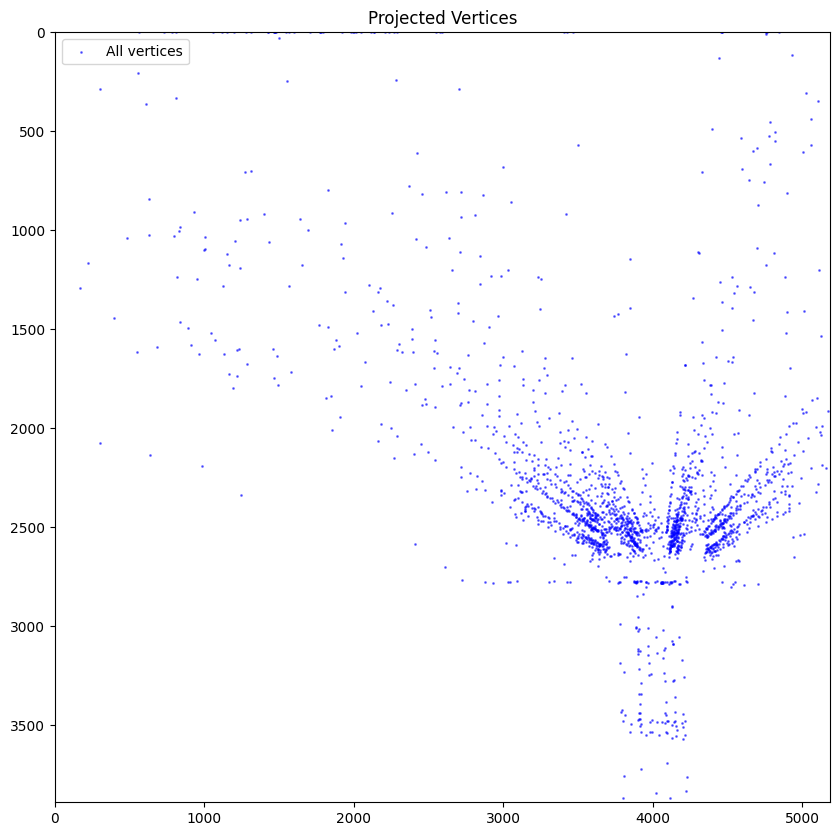

In [7]:
visualize_projected(projected_vertices, (camera_info["height"], camera_info["width"]))

In [8]:
image_size = (camera_info["height"], camera_info["width"])


print(f"Total vertices: {len((pier_cutted.vertices))}")
print(f"Vertices in image coordinates shape: {projected_vertices.shape}")
# in_front_of_camera = vertices_camera[:, 2] > 0
within_x_bounds = (projected_vertices[:, 0] >= 0) & (projected_vertices[:, 0] < image_size[1])
within_y_bounds = (projected_vertices[:, 1] >= 0) & (projected_vertices[:, 1] < image_size[0])
within_image_bounds = within_x_bounds & within_y_bounds

# potentially_visible = in_front_of_camera & within_image_bounds

potentially_visible = within_image_bounds
# print(f"Vertices in front of camera: {np.sum(in_front_of_camera)}")
print(f"Vertices within image boundaries: {np.sum(within_image_bounds)}")
print(f"Potentially visible vertices: {np.sum(potentially_visible)}")
potential_indices = np.where(potentially_visible)[0]      


Total vertices: 2201
Vertices in image coordinates shape: (2201, 2)
Vertices within image boundaries: 1980
Potentially visible vertices: 1980


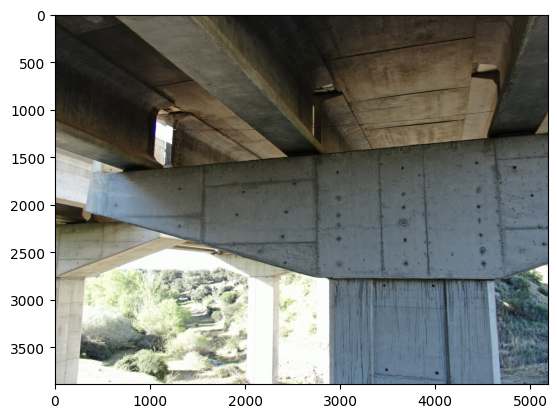

In [9]:
import cv2 as cv
import os 
IMG_FOLDER_PATH = 'image_selection_data/P_1'
FILE_FORMAT = '.JPG'
POSES_FOLDER = 'poses'
image_name = 'DJI_20240418185815_0195_Z'
image_path = os.path.join(IMG_FOLDER_PATH, image_name + FILE_FORMAT) 

img = cv.imread(image_path)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img) 
plt.show()

In [19]:
rays_directions = pier_cutted.vertices - center.squeeze()
distances = np.linalg.norm(rays_directions, axis=1)
rays_directions /= distances.reshape(-1, 1)
rays_origins = np.tile(center.squeeze(), (len(rays_directions), 1))


locations, index_ray, index_tri = pier_cutted.ray.intersects_location(
    ray_origins=rays_origins,
    ray_directions=rays_directions,
    multiple_hits=False
)

if locations.size == 0:
    print("error")
    
# Calculate distances from the center of all the projected points
distances = np.linalg.norm(locations - center.transpose(), axis=1).reshape(-1, 1)

defect_3d_vertices = np.zeros((len(projected_vertices), 3), dtype=np.float32)
correctly_projected_points = 0

visible = []
print('potential_indices', len(potential_indices))
for i in potential_indices:
    projected_points_for_i = locations[index_ray == i]

    if projected_points_for_i.size == 0:
        continue

    # distances_ray_i = distances[index_ray == i]
    # closest_index = np.argmin(distances_ray_i)
    # print(projected_points_for_i[closest_index])
    
    if projected_points_for_i.shape[0] < 2:
        visible.append(i)
    correctly_projected_points += 1
print('correctly_projected_points', correctly_projected_points)

potential_indices 1980
correctly_projected_points 1971


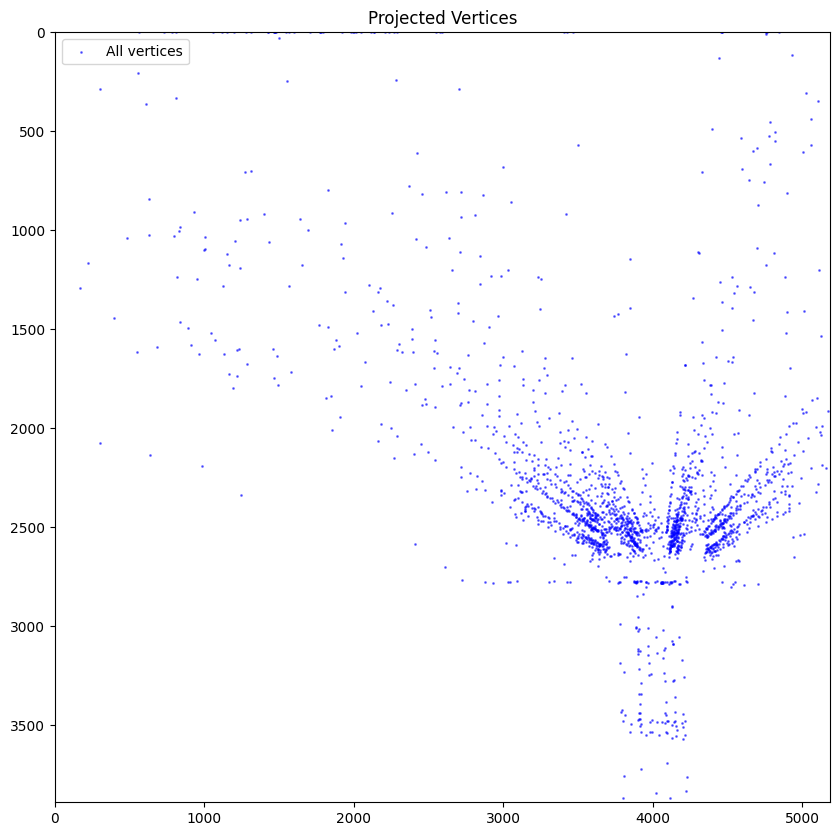

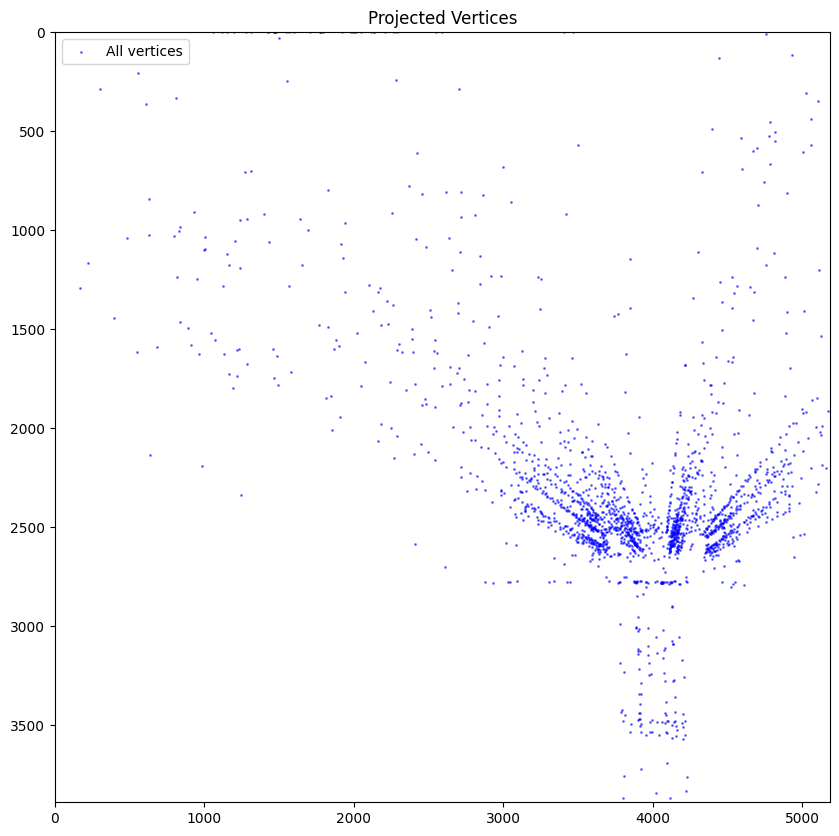

In [22]:
visualize_projected(projected_vertices, (camera_info["height"], camera_info["width"]))
visualize_projected(projected_vertices[visible], (camera_info["height"],  camera_info["width"]))

In [23]:
camera_position = center.squeeze()
# camera_position_fix = np.array([camera_position[1], camera_position[2], camera_position[0]])
visualize_results_interactive(pier_cutted, visible, camera_position, rotation, center)

In [42]:
scene = pier_cutted.scene()

def rotation_matrix_to_euler_angles(R):
    """Converts a rotation matrix to Euler angles (yaw, pitch, roll)."""

    sy = np.sqrt(R[0, 0] ** 2 + R[1, 0] ** 2)
    singular_case = sy < 1e-6

    if not singular_case:
        yaw = np.arctan2(R[1, 0], R[0, 0])
        pitch = -np.arcsin(R[2, 0])
        roll = np.arctan2(R[2, 1], R[2, 2])
    else:
        yaw = np.arctan2(-R[1, 2], R[0, 2])
        pitch = np.pi / 2 if R[2, 0] > 0 else -np.pi / 2
        roll = 0

    return yaw, pitch, roll

def get_camera_lookat_position(camera_position, camera_rotation, distance=1.0):
    """
    Calculate the 3D point where the camera is looking at and the distance from it.

    :param camera_position: 3D vector of the camera position (C_x, C_y, C_z).
    :param camera_rotation: 3x3 camera rotation matrix.
    :param distance: Scalar distance from the camera position to the look-at point (default 1.0).
    :return: Tuple (look_at_point, distance_from_look_at)
    """
    
    # Camera position (C_x, C_y, C_z)
    camera_position = np.array(camera_position)
    
    # Extract the forward direction from the rotation matrix
    forward_direction = camera_rotation[:, 2]  # The third column of the rotation matrix
    
    # Normalize the forward direction (just in case it's not unit length)
    forward_direction = forward_direction / np.linalg.norm(forward_direction)
    
    # Calculate the look-at point (a point in space where the camera is looking)
    look_at_point = camera_position + forward_direction * distance
    
    # Calculate the distance to the look-at point (optional, could be equal to input `distance`)
    actual_distance = np.linalg.norm(look_at_point - camera_position)
    
    return look_at_point, actual_distance


scene.camera.resolution = [camera_info["width"],camera_info["height"]]

look_at_point, actual_distance = get_camera_lookat_position(center.squeeze(), rotation)
scene.set_camera(angles=rotation_matrix_to_euler_angles(rotation), distance=actual_distance, center=look_at_point)


fov_x = np.rad2deg(2 * np.arctan2(camera_info["width"], 2 * camera_matrix[0,0]))
fov_y = np.rad2deg(2 * np.arctan2(camera_info["height"], 2 * camera_matrix[1,1]))
print('Camera FOV', (fov_x, fov_y))
scene.camera.focal = (camera_matrix[0,0], camera_matrix[1,1])


camera = scene.camera


origins, vectors, pixels = scene.camera_rays()




Camera FOV (56.73577690782599, 44.093967830377395)


In [43]:
# do the actual ray- mesh queries
points, index_ray, index_tri = pier_cutted.ray.intersects_location(
    origins, vectors, multiple_hits=False)

# for each hit, find the distance along its vector
depth = trimesh.util.diagonal_dot(points - origins[0],
                                    vectors[index_ray])
# find pixel locations of actual hits
pixel_ray = pixels[index_ray]

# create a numpy array we can turn into an image
# doing it with uint8 creates an `L` mode greyscale image
a = np.zeros(scene.camera.resolution, dtype=np.uint8)

# scale depth against range (0.0 - 1.0)
depth_float = ((depth - depth.min()) / depth.ptp())

# convert depth into 0 - 255 uint8
depth_int = (depth_float * 255).round().astype(np.uint8)
# assign depth to correct pixel locations
a[pixel_ray[:, 0], pixel_ray[:, 1]] = depth_int
# create a PIL image from the depth queries
img = PIL.Image.fromarray(a)

# show the resulting image
img.show()

ValueError: zero-size array to reduction operation minimum which has no identity